Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import re
import seaborn as sns
import datetime as dt


Read in the stations data from an URL, which includes all the Toronto Bike Share station names and locations (Lat and lon) (using 'request.get()'). This is a json file. After reading it in, it is converted to a pandas dataframe 'stations_df'.

In [2]:
#get stations info from online
#it's json file 
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

data = r.json()

stations = data['data']['stations']

#convert dict to dataframe
stations_df = pd.DataFrame(stations)

#view the dataframe
stations_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,nearby_distance,_ride_code_support,rental_uris,post_code,is_valet_station,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,True,{},NaN,NaN,NaN
1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,0.0,Yonge / Wellesley,23,True,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],416-617-9576,500.0,True,{},M4Y 1G7,NaN,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9615,500.0,True,{},NaN,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-631-4587,500.0,True,{},NaN,NaN,NaN
4,7005,King St W / York St,REGULAR,43.648001,-79.383177,0.0,King St W / York St,23,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9693,500.0,True,{},NaN,NaN,NaN


Select columns needed for further analysis ('station_id', 'name', 'lat', 'lon', and 'address'). Since the dataframe contains location information (lat and lon), the dataframe is then converted to a GeoDataFrame 'stations_loc'.

In [26]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   station_id              755 non-null    object 
 1   name                    755 non-null    object 
 2   physical_configuration  755 non-null    object 
 3   lat                     755 non-null    float64
 4   lon                     755 non-null    float64
 5   altitude                747 non-null    float64
 6   address                 754 non-null    object 
 7   capacity                755 non-null    int64  
 8   is_charging_station     755 non-null    bool   
 9   rental_methods          755 non-null    object 
 10  groups                  755 non-null    object 
 11  obcn                    755 non-null    object 
 12  nearby_distance         755 non-null    float64
 13  _ride_code_support      755 non-null    bool   
 14  rental_uris             755 non-null    ob

In [15]:
#select necessary info from stations_df
stations_location = stations_df[['station_id','name','lat', 'lon','address']]

#convert to geo dataframe
stations_loc = gpd.GeoDataFrame(data = stations_location, geometry = gpd.points_from_xy(stations_location['lon'],stations_location['lat'])) 

#set crs 
stations_loc.crs = {'init': 'epsg:4326'}
stations_loc = stations_loc.to_crs(epsg = 4326)


/Users/joycechen/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Load in the 'neighbourhoods' file, which is a shp file, and select only columns needed for further analysis, 'geometry' and 'FIELD_8'. Then 'FIELD_8' is renamed 'name'.

In [4]:
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')

In [5]:
#select columns needed and rename FIELD_8 to name
neighbourhoods = neighbourhoods[['geometry', 'FIELD_8']].rename(columns = {'FIELD_8':'name'})


Load the 2023 bikeshare dataset from the folder. 'bikeshare_2023.csv'. 

In [6]:
bikeshare_2023 = pd.read_csv('bikeshare_2023.csv')
bikeshare_2023.head()

,Unnamed: 0,ï»¿Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,0,20148784,840,7022,01/01/2023 00:00,Simcoe St / Queen St W,7703.0,01/01/2023 00:14,NaN,1770,Casual Member
1,1,20148785,722,7399,01/01/2023 00:01,Lower Jarvis / Queens Quay E,7533.0,01/01/2023 00:13,Housey St / Dan Leckie Way,6400,Casual Member
2,2,20148786,1054,7269,01/01/2023 00:02,Toronto Eaton Centre (Yonge St),7076.0,01/01/2023 00:20,York St / Queens Quay W,4068,Annual Member
3,3,20148790,1329,7721,01/01/2023 00:04,NaN,7685.0,01/01/2023 00:26,NaN,427,Casual Member
4,4,20148791,1291,7721,01/01/2023 00:04,NaN,7685.0,01/01/2023 00:26,NaN,1840,Casual Member


Rename the column names so that it's easier to index them.

In [7]:
bikeshare_2023 = bikeshare_2023.rename(columns = {'ï»¿Trip Id':'trip id', 'Trip  Duration': 'trip duration','Start Time':'start time','Start Station Id':'start station id','End Station Id':'end station id','End Time':'end time','User Type':'user type'})
bikeshare_2023.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577456 entries, 0 to 577455
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          577456 non-null  int64  
 1   trip id             577456 non-null  int64  
 2   trip duration       577456 non-null  int64  
 3   start station id    577456 non-null  int64  
 4   start time          577456 non-null  object 
 5   Start Station Name  540508 non-null  object 
 6   end station id      577213 non-null  float64
 7   end time            577456 non-null  object 
 8   End Station Name    539487 non-null  object 
 9   Bike Id             577456 non-null  int64  
 10  user type           577456 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 48.5+ MB


Any entries with trip duration 'trip duration' less than 1 min and greater than 1 hour are outliers, which could happen due to system error. Remove these entries from the dataframe, and call this new dataframe 'bikeshare_2023_cleaned'.

In [8]:
bikeshare_2023_cleaned = bikeshare_2023.loc[(bikeshare_2023['trip duration']>=60) & (bikeshare_2023['trip duration']<=3600)] #3600 sec = 1 hour

bikeshare_2023_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572593 entries, 0 to 577455
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          572593 non-null  int64  
 1   trip id             572593 non-null  int64  
 2   trip duration       572593 non-null  int64  
 3   start station id    572593 non-null  int64  
 4   start time          572593 non-null  object 
 5   Start Station Name  535930 non-null  object 
 6   end station id      572586 non-null  float64
 7   end time            572593 non-null  object 
 8   End Station Name    535193 non-null  object 
 9   Bike Id             572593 non-null  int64  
 10  user type           572593 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 52.4+ MB


In [9]:
bikeshare_2023_cleaned.head()

,Unnamed: 0,trip id,trip duration,start station id,start time,Start Station Name,end station id,end time,End Station Name,Bike Id,user type
0,0,20148784,840,7022,01/01/2023 00:00,Simcoe St / Queen St W,7703.0,01/01/2023 00:14,NaN,1770,Casual Member
1,1,20148785,722,7399,01/01/2023 00:01,Lower Jarvis / Queens Quay E,7533.0,01/01/2023 00:13,Housey St / Dan Leckie Way,6400,Casual Member
2,2,20148786,1054,7269,01/01/2023 00:02,Toronto Eaton Centre (Yonge St),7076.0,01/01/2023 00:20,York St / Queens Quay W,4068,Annual Member
3,3,20148790,1329,7721,01/01/2023 00:04,NaN,7685.0,01/01/2023 00:26,NaN,427,Casual Member
4,4,20148791,1291,7721,01/01/2023 00:04,NaN,7685.0,01/01/2023 00:26,NaN,1840,Casual Member


Join bikeshare data 'bikeshare_2023_cleaned' with station location data 'stations_location'. Then convert this new dataframe to a GeoDataFrame.
Note that 'station_id' and 'start station id' are the common stations from the two dataframes, but now they are different data types. Therefore, 'station_id' from 'station_location' is converted to 'int' first.

In [10]:
stations_location['station_id'] = stations_location['station_id'].astype(int)
stations_location.head()

/var/folders/5j/22sv3wgn7k7cftl76slzc3900000gn/T/ipykernel_18213/1989264499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_location['station_id'] = stations_location['station_id'].astype(int)


,station_id,name,lat,lon,address
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,Fort York Blvd / Capreol Ct
1,7001,Wellesley Station Green P,43.664964,-79.383550,Yonge / Wellesley
2,7002,St. George St / Bloor St W,43.667333,-79.399429,St. George St / Bloor St W
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,Madison Ave / Bloor St W
4,7005,King St W / York St,43.648001,-79.383177,King St W / York St


In [11]:
bike_2023 = pd.merge(bikeshare_2023_cleaned,stations_location, left_on = 'start station id', right_on = 'station_id')

bike_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547328 entries, 0 to 547327
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          547328 non-null  int64  
 1   trip id             547328 non-null  int64  
 2   trip duration       547328 non-null  int64  
 3   start station id    547328 non-null  int64  
 4   start time          547328 non-null  object 
 5   Start Station Name  511515 non-null  object 
 6   end station id      547321 non-null  float64
 7   end time            547328 non-null  object 
 8   End Station Name    511363 non-null  object 
 9   Bike Id             547328 non-null  int64  
 10  user type           547328 non-null  object 
 11  station_id          547328 non-null  int64  
 12  name                547328 non-null  object 
 13  lat                 547328 non-null  float64
 14  lon                 547328 non-null  float64
 15  address             547328 non-nul

Now that the bikeshare dataframe has latitude and longitude for each entry. This dataframe is converted to a GeoDataFrame.

In [12]:
#convert to geo dataframe
bike_2023_gdf = gpd.GeoDataFrame(data = bike_2023, geometry = gpd.points_from_xy(bike_2023['lon'],bike_2023['lat']))

bike_2023_gdf.head()

,Unnamed: 0,trip id,trip duration,start station id,start time,Start Station Name,end station id,end time,End Station Name,Bike Id,user type,station_id,name,lat,lon,address,geometry
0,0,20148784,840,7022,01/01/2023 00:00,Simcoe St / Queen St W,7703.0,01/01/2023 00:14,NaN,1770,Casual Member,7022,Simcoe St / Queen St W,43.65049,-79.3873,Simcoe St / Queen St W,POINT (-79.38730 43.65049)
1,131,20148934,843,7022,01/01/2023 00:43,Simcoe St / Queen St W,7109.0,01/01/2023 00:57,Seaton St / Dundas St E - SMART,4896,Annual Member,7022,Simcoe St / Queen St W,43.65049,-79.3873,Simcoe St / Queen St W,POINT (-79.38730 43.65049)
2,232,20149050,1468,7022,01/01/2023 01:07,Simcoe St / Queen St W,7079.0,01/01/2023 01:31,McGill St / Church St,7232,Casual Member,7022,Simcoe St / Queen St W,43.65049,-79.3873,Simcoe St / Queen St W,POINT (-79.38730 43.65049)
3,526,20149368,613,7022,01/01/2023 02:07,Simcoe St / Queen St W,7046.0,01/01/2023 02:17,Niagara St / Richmond St W,671,Casual Member,7022,Simcoe St / Queen St W,43.65049,-79.3873,Simcoe St / Queen St W,POINT (-79.38730 43.65049)
4,529,20149371,807,7022,01/01/2023 02:07,Simcoe St / Queen St W,7203.0,01/01/2023 02:21,Bathurst St/Queens Quay(Billy Bishop Airport),6090,Casual Member,7022,Simcoe St / Queen St W,43.65049,-79.3873,Simcoe St / Queen St W,POINT (-79.38730 43.65049)


Assign crs to this new GeoDataFrame. Set epsg to 4326.

In [13]:
bike_2023_gdf.crs = {'init': 'epsg:4326'}
bike_2023_gdf =bike_2023_gdf.to_crs(epsg = 4326)


/Users/joycechen/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


This line of code calculate many trips there are in one neighbourhood in 2023. The result is assigned to a new column 'trips'.

In [33]:
#number of trips made in each neighbourhood
neighbourhoods['trips'] = neighbourhoods.apply(lambda row: bike_2023_gdf.within(row.geometry).sum(), axis = 1)

#number of stations at each neighborhood
neighbourhoods['stations'] = neighbourhoods.apply(lambda row: stations_loc.within(row.geometry).sum(), axis = 1)



neighbourhoods.head()

ValueError: Cannot set a DataFrame with multiple columns to the single column no stations

In [47]:
neighbourhoods['no stations'] = ['Zero stations' if num == 0 else ' Has stations' for num in neighbourhoods['stations']]
neighbourhoods['no stations'].unique()

array([' Has stations', 'Zero stations'], dtype=object)

In [25]:
neighbourhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  140 non-null    geometry
 1   name      140 non-null    object  
 2   trips     140 non-null    int64   
 3   stations  140 non-null    int64   
dtypes: geometry(1), int64(2), object(1)
memory usage: 4.5+ KB


In [29]:
min_stations = neighbourhoods.sort_values(by = 'stations')
min_stations = min_stations.loc[min_stations['stations'] == 0]
min_stations



,geometry,name,trips,stations
69,"POLYGON ((-79.44043 43.76340, -79.44052 43.763...",Willowdale West (37),0,0
81,"POLYGON ((-79.35966 43.76649, -79.36014 43.766...",Bayview Village (52),0,0
76,"POLYGON ((-79.54866 43.59022, -79.54876 43.590...",Alderwood (20),0,0
75,"POLYGON ((-79.25498 43.78122, -79.25797 43.780...",Agincourt South-Malvern West (128),0,0
74,"POLYGON ((-79.24213 43.80247, -79.24319 43.802...",Agincourt North (129),0,0
71,"POLYGON ((-79.21128 43.75113, -79.21135 43.751...",Woburn (137),0,0
70,"POLYGON ((-79.52661 43.68233, -79.52705 43.682...",Willowridge-Martingrove-Richview (7),0,0
82,"POLYGON ((-79.39623 43.80327, -79.39443 43.803...",Bayview Woods-Steeles (49),0,0
68,"POLYGON ((-79.41225 43.76669, -79.41232 43.766...",Willowdale East (51),0,0
63,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",West Humber-Clairville (1),0,0


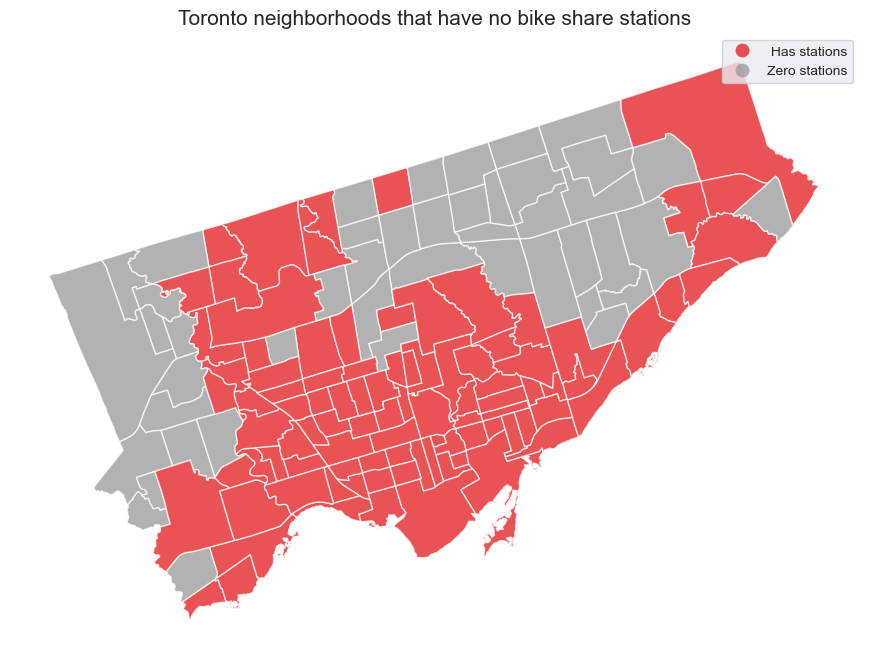

In [53]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75, column = 'no stations', legend = True,cmap='Set1')

plt.title('Toronto neighborhoods that have no bike share stations', fontsize = 15)

plt.axis('off')

plt.savefig('no_stations_neighborhoods.png')



Plot figures and maps. 
First load folium:

In [62]:
import folium

In [63]:
from folium import Marker
from folium import Circle
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

Distribution of annual and casual memberships in different neighbourhoods in Toronto
First, separate 'bike_2023_gdf' into two dataframes, one with all annual memberships 'annual' and the other all casual memberships 'casual'. 
Then, the same crs is assigned to both 'annual' and 'casual' dataframes.

In [64]:
annual = bike_2023_gdf.loc[bike_2023_gdf['user type'] == 'Annual Member']
annual.head()
#set crs
annual.crs = {'init': 'epsg:4326'}
annual =annual.to_crs(epsg = 4326)

casual = bike_2023_gdf.loc[bike_2023_gdf['user type'] == 'Casual Member']

casual.crs = {'init': 'epsg:4326'}
casual =casual.to_crs(epsg = 4326)
casual.info()

/Users/joycechen/PycharmProjects/pythonProject3/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/joycechen/PycharmProjects/pythonProject3/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 414569 entries, 0 to 552925
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Unnamed: 0          414569 non-null  int64   
 1   trip id             414569 non-null  int64   
 2   trip duration       414569 non-null  int64   
 3   start station id    414569 non-null  int64   
 4   start time          414569 non-null  object  
 5   Start Station Name  387892 non-null  object  
 6   end station id      414563 non-null  float64 
 7   end time            414569 non-null  object  
 8   End Station Name    387771 non-null  object  
 9   Bike Id             414569 non-null  int64   
 10  user type           414569 non-null  object  
 11  station_id          414569 non-null  int64   
 12  lat                 414569 non-null  float64 
 13  lon                 414569 non-null  float64 
 14  geometry            414569 non-null  geometry
dtypes: float64(3),

How many annual/casual membership trips are made in each neighbourhoods:

In [66]:
#how many annual member trips in one neighbourhoods
neighbourhoods['annual'] = neighbourhoods.apply(lambda row: annual.within(row.geometry).sum(), axis = 1)

neighbourhoods['casual'] = neighbourhoods.apply(lambda row: casual.within(row.geometry).sum(), axis = 1)

neighbourhoods.head()

,geometry,name,trips,annual,casual
0,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",Wychwood (94),3001,761,2240
1,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",Yonge-Eglinton (100),2107,398,1709
2,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",Yonge-St.Clair (97),498,116,382
3,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",York University Heights (27),399,32,367
4,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",Yorkdale-Glen Park (31),0,0,0


Plot the neighbourhoods locations on a map with different shades of color indicating different numbers of annual membership trips.

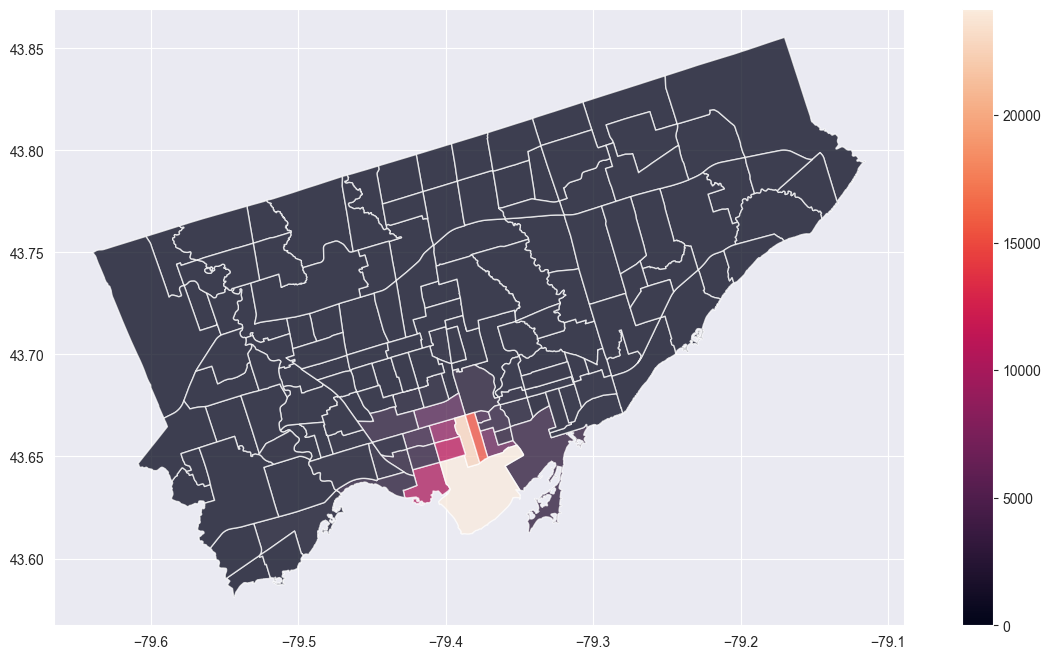

In [67]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75, column = 'annual', legend = True)
#the darker it is the more annual member trips

Do the same with casual memberships. The final map shows all the neighbourhoods in Toronto, with different shades of color indicating different of casual membership trips.

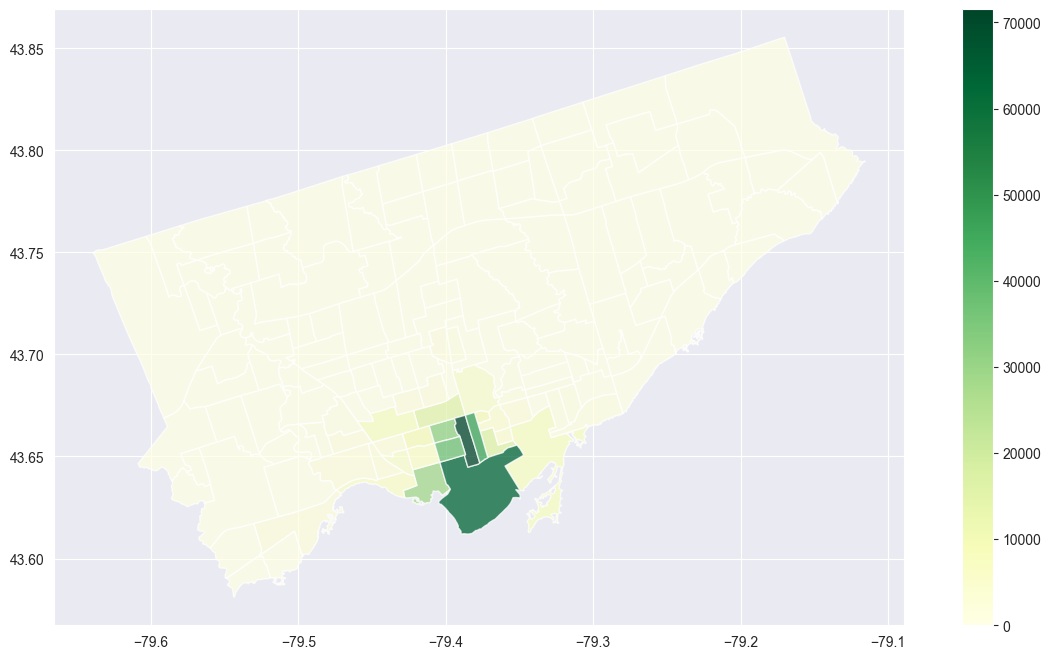

In [68]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75, column = 'casual', legend = True,cmap='YlGn')

Do the same with total number of trips.

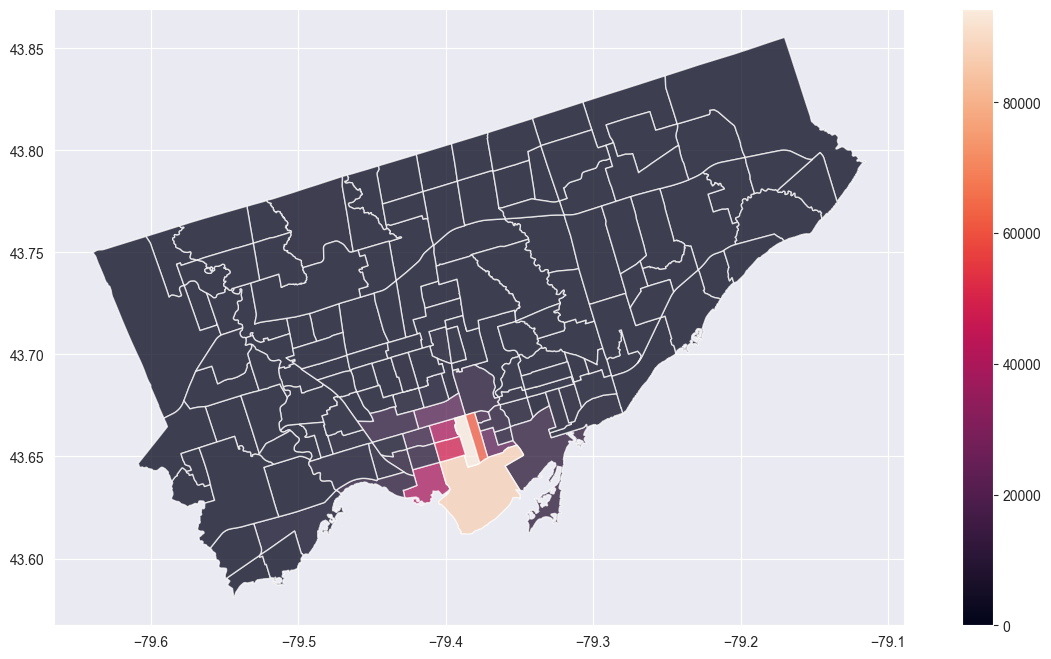

In [69]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75, column = 'trips', legend = True)


In [45]:
import seaborn as sns
import datetime as dt

for each station, subtract number of trips started from this station from number of trips ended in this stations.
1. Separate 'from_station_id' and 'from_station_name' from 'to_station_id' and 'to_station_name'
2. count number of trips started/ended in a station in two separate dataframes

In [46]:
bike_2023.head()

,Unnamed: 0,trip id,trip duration,start station id,Start Time,Start Station Name,end station id,End Time,End Station Name,Bike Id,user type,station_id,lat,lon
0,0,20148784,840,7022,01/01/2023 00:00,Simcoe St / Queen St W,7703.0,01/01/2023 00:14,NaN,1770,Casual Member,7022,43.65049,-79.3873
1,131,20148934,843,7022,01/01/2023 00:43,Simcoe St / Queen St W,7109.0,01/01/2023 00:57,Seaton St / Dundas St E - SMART,4896,Annual Member,7022,43.65049,-79.3873
2,232,20149050,1468,7022,01/01/2023 01:07,Simcoe St / Queen St W,7079.0,01/01/2023 01:31,McGill St / Church St,7232,Casual Member,7022,43.65049,-79.3873
3,526,20149368,613,7022,01/01/2023 02:07,Simcoe St / Queen St W,7046.0,01/01/2023 02:17,Niagara St / Richmond St W,671,Casual Member,7022,43.65049,-79.3873
4,529,20149371,807,7022,01/01/2023 02:07,Simcoe St / Queen St W,7203.0,01/01/2023 02:21,Bathurst St/Queens Quay(Billy Bishop Airport),6090,Casual Member,7022,43.65049,-79.3873


In [19]:
from_df = bike_2023
from_df['date'] = pd.to_datetime(from_df['Start Time']).dt.date
from_df = bike_2023.groupby(['date','start station id']).agg({'trip id':'count'}).reset_index()
from_df = from_df.rename(columns = {'trip id':'from trip counts'})

to_df = bike_2023
to_df['date'] = pd.to_datetime(to_df['Start Time']).dt.date
to_df = bike_2023.groupby(['date','end station id']).agg({'trip id':'count'}).reset_index()
to_df = to_df.rename(columns = {'trip id':'to trip counts'})

to_df.head()

,date,end station id,to trip counts
0,2023-01-01,7000.0,26
1,2023-01-01,7001.0,18
2,2023-01-01,7002.0,7
3,2023-01-01,7003.0,11
4,2023-01-01,7004.0,3


In [20]:
to_and_from = pd.merge(to_df,from_df,left_on = 'end station id', right_on = 'start station id' )


to_and_from['bike_dif'] = to_and_from['to trip counts'] - to_and_from['from trip counts']

lack_capacity =to_and_from.loc[to_and_from['bike_dif'] <0]

lack_capacity.head()



,date_x,end station id,to trip counts,date_y,start station id,from trip counts,bike_dif
1,2023-01-01,7000.0,26,2023-01-02,7000,36,-10
2,2023-01-01,7000.0,26,2023-01-03,7000,27,-1
6,2023-01-01,7000.0,26,2023-01-07,7000,39,-13
8,2023-01-01,7000.0,26,2023-01-09,7000,34,-8
9,2023-01-01,7000.0,26,2023-01-10,7000,37,-11


3. Join stations_df with each dataframe. Then Join the final two dataframes. 
4. Subtract

In [44]:
lack_capacity = lack_capacity.groupby('start station id').agg({'bike_dif':'count'}).reset_index()
lack_capacity.head()

,start station id,bike_dif
0,7000,4766
1,7001,4210
2,7002,4146
3,7003,4892
4,7004,4459


In [45]:
stations_location['station_id'] = stations_location['station_id'].astype('int')
temp_stations = pd.merge(lack_capacity, stations_location, left_on = 'start station id', right_on='station_id', how = 'left' )

# temp_stations = temp_stations[['from_station_id', 'to_trip_counts','from_trip_counts','capacity']]

#if bike_avaialble is negative, then there is more bikes being taken from this station than returned. negative number means capacity need to be increased.


temp_stations.head()

,start station id,bike_dif,station_id,lat,lon
0,7000,4766,7000,43.639832,-79.395954
1,7001,4210,7001,43.664964,-79.383550
2,7002,4146,7002,43.667333,-79.399429
3,7003,4892,7003,43.667158,-79.402761
4,7004,4459,7004,43.656518,-79.389099


5. join the dataframe that contains the stations whose capacity needed to be increased with stations_location, to get the lat and lon of the stations.
6. Then convert the dataframe to Geodataframes.

In [46]:
# stations_location['station_id'] = stations_location['station_id'].astype('int')
# capacity_increase = pd.merge(temp_stations, stations_location, how = 'left', left_on='start station id', right_on='station_id' )
# 
# # capacity_increase = capacity_increase[['start station id', 'lat','lon']]
# # 
capacity_increase = temp_stations
capacity_increase= gpd.GeoDataFrame(data = capacity_increase, geometry = gpd.points_from_xy(capacity_increase['lon'],capacity_increase['lat']))

capacity_increase.head()

,start station id,bike_dif,station_id,lat,lon,geometry
0,7000,4766,7000,43.639832,-79.395954,POINT (-79.39595 43.63983)
1,7001,4210,7001,43.664964,-79.383550,POINT (-79.38355 43.66496)
2,7002,4146,7002,43.667333,-79.399429,POINT (-79.39943 43.66733)
3,7003,4892,7003,43.667158,-79.402761,POINT (-79.40276 43.66716)
4,7004,4459,7004,43.656518,-79.389099,POINT (-79.38910 43.65652)


In [47]:

capacity_increase.crs = {'init': 'epsg:4326'}
capacity_increase = capacity_increase.to_crs(epsg = 4326)

/Users/joycechen/PycharmProjects/pythonProject3/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


plot

In [49]:
capacity_increase.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   start station id  637 non-null    int64   
 1   bike_dif          637 non-null    int64   
 2   station_id        637 non-null    int64   
 3   lat               637 non-null    float64 
 4   lon               637 non-null    float64 
 5   geometry          637 non-null    geometry
dtypes: float64(2), geometry(1), int64(3)
memory usage: 30.0 KB


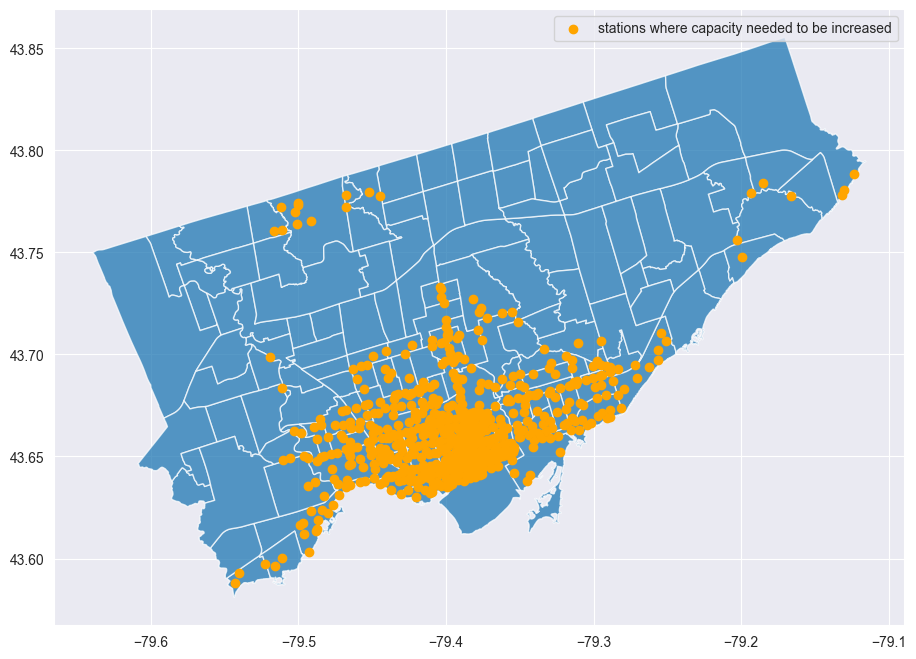

In [48]:


ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
capacity_increase.plot(ax=ax, color='orange', label='stations where capacity needed to be increased')


plt.legend()